<a href="https://colab.research.google.com/github/USCbiostats/PM520/blob/main/Lab_6_Divergences.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Them Changes, or: Fisher Information, Statistical Divergences & Natural Gradient Descent

Recall last week we informally covered [Exponential Families](https://en.wikipedia.org/wiki/Exponential_family) and discussed how to perform MLE inference.

Today we'll take an informal look at Fisher Information,


Next, we'll transition into [statistical divergences](https://en.wikipedia.org/wiki/Divergence_%28statistics%29), which reflect notions of a "distance" between parametric distributions.

Lastly, we look at another means to perform optimization, but different from previous approaches, we show how to generalize notions of "steepest" to consider the underlying geometry in a distributional sense through *natural* gradient descent.

## Fisher Information and KL for ExpFam
Informally, the  [Fisher Information](https://en.wikipedia.org/wiki/Fisher_information) provides a measure of the amount of [information](https://en.wikipedia.org/wiki/Information) that a random variable carries about model parameters $\theta$.

TBD: Definition, Bernoulli example ...

## Statistical Divergences
[Divergences](https://en.wikipedia.org/wiki/Divergence_%28statistics%29) capture a notion of "[statistical distance](https://en.wikipedia.org/wiki/Statistical_distance)" between parameterized distribution functions. Their full definition is beyond the scope of this course, but key properties to recall are, given distributions $q$ and $p$ over the same [sample space](https://en.wikipedia.org/wiki/Sample_space), a divergence statisfies $D(p || q) \geq 0$ and $D(p || q) = 0$ iff $p = q$. There are many [different kinds](https://en.wikipedia.org/wiki/Divergence_%28statistics%29%23Examples) of divergences, but a very commonly used divergence is the [Kullback-Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence), or KL divergence.

For discrete $x$ with sample space $\mathcal{X}$, we have,
$$
\begin{align*}
D_{KL}(p || q) &= \sum_{x \in \mathcal{X}} p(x) \log \frac{p(x)}{q(x)} = - \sum_{x \in \mathcal{X}} p(x) \log \frac{q(x)}{p(x)} \\
  &= -\mathbb{E}_{x \sim p}\left[\log \frac{q(x)}{p(x)} \right].
\end{align*}$$

Fo continuous $x \in \mathbb{R}$, we have,
$$\begin{align*}
D_{KL}(p || q) &= \int_{-\infty}^\infty p(x) \log \frac{p(x)}{q(x)}dx = -\int_{-\infty}^\infty p(x) \log \frac{q(x)}{p(x)}dx \\
  &= -\mathbb{E}_{x \sim p}\left[\log \frac{q(x)}{p(x)} \right].
\end{align*}$$

## Example: Normal Distribution
Let $p := N(\mu_p, \sigma^2_p)$ and $q := N(\mu_q, \sigma^2_q).$ The KL divergence between $p, q$ is given by,
$$D_{KL}(p || q) = \frac{(\mu_p - \mu_q)^2}{2 \sigma^2_q} + \frac{1}{2}\left(\frac{\sigma^2_p}{\sigma^2_q} - 1 - \ln \frac{\sigma^2_p}{\sigma^2_q} \right).$$

Let's plot a few examples to get an intuition of how this is useful.

t1 = 50.0 | t2 = 0.0
t1 = 3.125 | t2 = 0.0
KL divergence in setting 1: 50.0 and setting 2: 3.125
Euclidean distance in setting 1: 25.0 and setting 2: 25.0


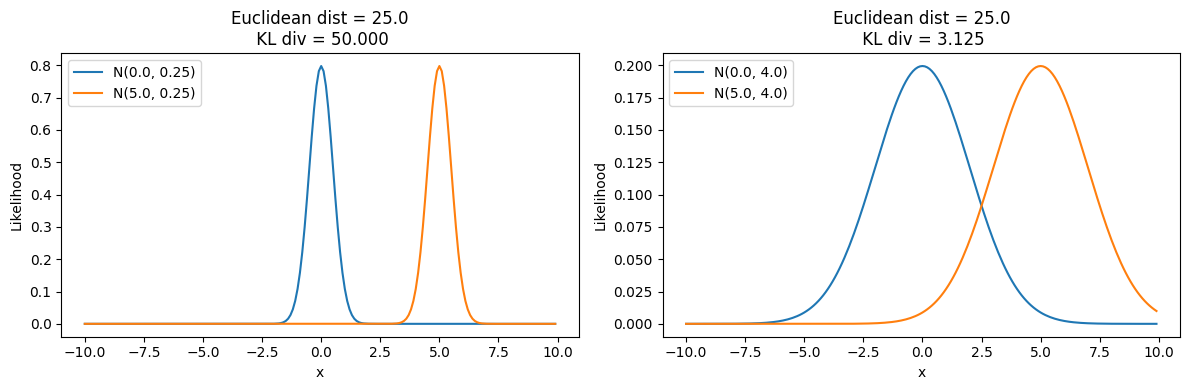

In [ ]:
import jax.numpy as jnp
import jax.scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot as plt

# Example data
x_values = jnp.arange(-10, 10, 0.1)

# let's code up KL divergence for scalar normals
def kl_normal(mu1, var1, mu2, var2):
  term1 = (mu1 - mu2) ** 2 / (2 * var2)
  term2 = 0.5 * (var1/var2 - 1 - jnp.log(var1) + jnp.log(var2))
  print(f"t1 = {term1} | t2 = {term2}")
  return term1 + term2

# scenario 1
mu_1 = 0.
mu_2 = 5.
std_11 = std_12 = 0.5
y_values11 = stats.norm.pdf(x_values, mu_1, std_11)  # N(mu_1, std_1**2)
y_values12 = stats.norm.pdf(x_values, mu_2, std_12)  # N(mu_2, std_1**2)

param_11 = jnp.array([mu_1, std_1**2])
param_12 = jnp.array([mu_2, std_2**2])

# calc euclidean distances between distributions 1 and 2 for scenario 1
e_dist_1 = jnp.sum((param_11 - param_12) ** 2)

# whats the KL divergence between for scenario 1
kl_div_1 = kl_normal(mu_1, std_11 ** 2, mu_2, std_12 ** 2)

# scenario 2
mu_1 = 0.
mu_2 = 5.
std_21 = std_22 = 2.0
y_values21 = stats.norm.pdf(x_values, mu_1, std_21)  # N(mu_1, std_2**2)
y_values22 = stats.norm.pdf(x_values, mu_2, std_22)  # N(mu_2, std_2**2)

param_21 = jnp.array([mu_1, std_21**2])
param_22 = jnp.array([mu_2, std_22**2])

e_dist_2 = jnp.sum((param_21 - param_22) ** 2)
kl_div_2 = kl_normal(mu_1, std_21 ** 2, mu_2, std_22 ** 2)

print(f"KL divergence in setting 1: {kl_div_1} and setting 2: {kl_div_2}")
print(f"Euclidean distance in setting 1: {e_dist_1} and setting 2: {e_dist_2}")

# Create a figure and a 1x2 grid of subplots (for horizontal alignment)
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot on the first subplot
sns.lineplot(x=x_values, y=y_values11, ax=axs[0], label=f"N({mu_1}, {std_11**2})")
sns.lineplot(x=x_values, y=y_values12, ax=axs[0], label=f"N({mu_2}, {std_12**2})")
axs[0].set_title(f"Euclidean dist = {e_dist_1}\n KL div = {kl_div_1:.3f}")
axs[0].set_xlabel('x')
axs[0].set_ylabel('Likelihood')

# Plot on the second subplot
sns.lineplot(x=x_values, y=y_values21, ax=axs[1], label=f"N({mu_1}, {std_21**2})")
sns.lineplot(x=x_values, y=y_values22, ax=axs[1], label=f"N({mu_2}, {std_22**2})")
axs[1].set_title(f"Euclidean dist = {e_dist_2}\n KL div = {kl_div_2:.3f}")
axs[1].set_xlabel('x')
axs[1].set_ylabel('Likelihood')

# Display the plot
plt.tight_layout()  # Adjust the layout to not overlap
plt.show()

In the above example, the Euclidean distance between the blue and orange distributions was the same, but the wider variance setting on the right "feels" like they should be more similar, given the larger overlap at relatively high density regions. This was reflected in the much lower KL divergence in the second scenario.

Let's try another example, but this time using discrete observations from Poisson distribution

KL divergence in setting 1: 2.390562057495117 and setting 2: 1.0610668659210205
Euclidean distance in setting 1: 4.0 and setting 2: 4.0


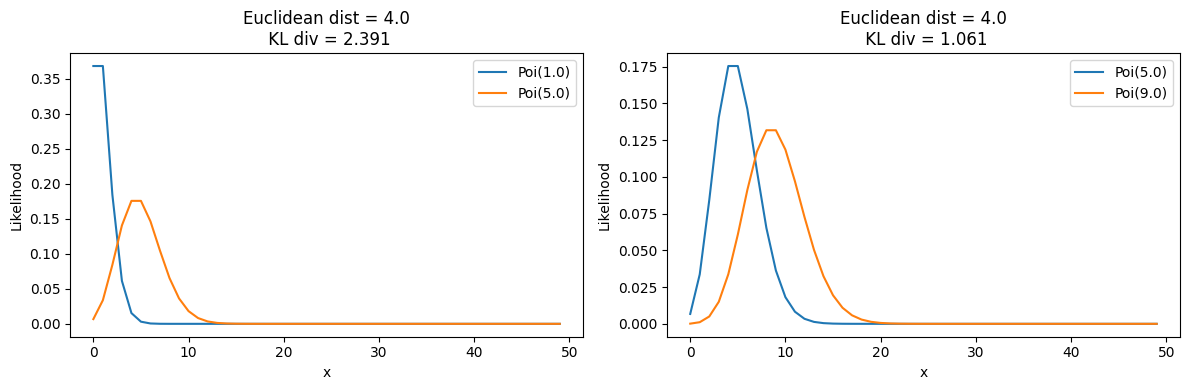

In [ ]:
from jax.scipy.special import xlogy

# xlogy(x, y) = x * log(y)

# Example data
x_values = jnp.arange(0, 50)

# let's code up KL divergence for poisson
# hint: https://en.wikipedia.org/wiki/Poisson_distribution#Other_properties
def kl_poisson(rate1, rate2):
  ...

# scenario 1
rate_11 = 1.
rate_12 = 5.
y_values11 = stats.poisson.pmf(x_values, rate_11)  # Poi(rate_1)
y_values12 = stats.poisson.pmf(x_values, rate_12)  # Poi(rate_2)

# calc euclidean distances between distributions 1 and 2 for scenario 1
e_dist_1 = jnp.fabs(rate_11 - rate_12)

# whats the KL divergence between for scenario 1
kl_div_1 = kl_poisson(rate_11, rate_12)

# scenario 2
rate_21 = 5.
rate_22 = 9.
y_values21 = stats.poisson.pmf(x_values, rate_21)  # Poi(rate_1)
y_values22 = stats.poisson.pmf(x_values, rate_22)  # Poi(rate_2)

e_dist_2 = jnp.fabs(rate_21 - rate_22)
kl_div_2 = kl_poisson(rate_21, rate_22)

print(f"KL divergence in setting 1: {kl_div_1} and setting 2: {kl_div_2}")
print(f"Euclidean distance in setting 1: {e_dist_1} and setting 2: {e_dist_2}")

# Create a figure and a 1x2 grid of subplots (for horizontal alignment)
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot on the first subplot
sns.lineplot(x=x_values, y=y_values11, ax=axs[0], label=f"Poi({rate_11})")
sns.lineplot(x=x_values, y=y_values12, ax=axs[0], label=f"Poi({rate_12})")
axs[0].set_title(f"Euclidean dist = {e_dist_1}\n KL div = {kl_div_1:.3f}")
axs[0].set_xlabel('x')
axs[0].set_ylabel('Likelihood')

# Plot on the second subplot
sns.lineplot(x=x_values, y=y_values21, ax=axs[1], label=f"Poi({rate_21})")
sns.lineplot(x=x_values, y=y_values22, ax=axs[1], label=f"Poi({rate_22})")
axs[1].set_title(f"Euclidean dist = {e_dist_2}\n KL div = {kl_div_2:.3f}")
axs[1].set_xlabel('x')
axs[1].set_ylabel('Likelihood')

# Display the plot
plt.tight_layout()  # Adjust the layout to not overlap
plt.show()

## Natural Gradient Descent
Recall under [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent) we can iteratively optimize a function $f(\theta)$ by taking steps in the steepest direction,
$$ \theta_{t+1} = \theta_t - \rho_t \nabla f(\theta_t).$$
Interestingly, we can re-write this update as a *local* optimization problem,
$$ \theta_{t+1} = {\arg \min}_{\theta} \ \ \theta \cdot \nabla f(\theta_t) + \frac{1}{2\rho_t}||\theta - \theta_t||^2.$$
The intuition is that we'd like to find some $\theta$ which finds a direction that decreases $f$ at $\theta_t$, as rapidly as possible (i.e. $\nabla f(\theta_t)$ itself), while not moving too "far" away from $\theta_t$  where "far" is captured by a [*Euclidean distance*](https://en.wikipedia.org/wiki/Euclidean_distance) (i.e. $||\theta - \theta_t||^2$).

To see their equivalence we have,
$$\begin{align*}
& \frac{\partial}{\partial \theta} \left[\theta \cdot \nabla f(\theta_t) + \frac{1}{2\rho_t}||\theta - \theta_t||^2 \right] \\
 &= \frac{\partial}{\partial \theta} [\theta \cdot \nabla f(\theta_t)] + \frac{1}{2\rho_t}\frac{\partial}{\partial \theta} ||\theta - \theta_t||^2 \\
   &= \nabla f(\theta_t) - \frac{(\theta - \theta_t)}{\rho_t} ⇒ \\
   \theta_{t+1} &= \theta_t - \rho_t \nabla f(\theta_t).
\end{align*}$$

We saw [above](#statistical-divergences) how Euclidean distance can lead to less meaningful measures of distance when we care about parameters underlying statistical distributions. Can we improve inference if we used a notion of *statistical distance* or (surprise) *divergence* in the above formulation?

Let's replace $||\theta - \theta_t||^2$ with KL divergence,
$$\begin{align*}
\theta_{t+1} &= {\arg \min}_{\theta} \ \ \theta \cdot \nabla f(\theta_t) + \frac{1}{2\rho_t}D_{KL}(\theta||\theta_t) \\
  &\approx {\arg \min}_{\theta} \ \ \theta \cdot \nabla f(\theta_t) + \frac{1}{2\rho_t}(\theta - \theta_t)^T F(\theta_t)(\theta - \theta_t) ⇒ \\
\theta_{t+1} &= \theta_t - \rho_t F^{-1}(\theta_t)∇f(\theta_t) \\
  &= \theta_t - \rho_t \widetilde{\nabla} f(\theta_t).
\end{align*}$$

where $\widetilde{\nabla} f(\theta_t)$ is the *natural* gradient, defined as $ \widetilde{\nabla} f(\theta_t) := F^{-1}(\theta_t)∇f(\theta_t)$ and $F(\theta_t) = \mathbb{E}_{x \sim p(\theta_t)}\left[∇\log p(x | \theta_t)\nabla \log p(x | \theta_t)^T\right]$ is the [Fisher Information Matrix](https://en.wikipedia.org/wiki/Fisher_information).

To arrive at the approximation, we take the second-roder Taylor series of $D_{KL}$ TBD.

In [ ]:
# code for later

## Example: Normal distribution
Let's assume that $\theta = [\mu, \sigma^2]^T$ are parameters for a Normal distribution.

Let's assume that $\nabla f(\theta_t) = [\frac{\partial}{\partial \mu} f(\theta_t), \frac{\partial}{\partial \sigma^2} f(\theta_t)]^T$ is given and recall that $F(\theta_t) = \begin{bmatrix} \frac{1}{\sigma^2} & 0 \\ 0 & \frac{1}{2\sigma^4}\end{bmatrix}$ which gives
$F(\theta_t)^{-1} = \begin{bmatrix} \sigma^2 & 0 \\ 0 & 2\sigma^4\end{bmatrix}$.

Recall the definition of *natural gradient* step given by,
$$\begin{align*}
\theta_{t+1} &= \theta_t - \rho_t F^{-1}(\theta_t)∇f(\theta_t) \\
  &= \theta_t - \rho_t \widetilde{\nabla} f(\theta_t).
\end{align*}$$

Work out what the natural gradient step for $\mu_{t+1}$ and $\sigma^2_{t+1}$ are respectively.

$$\begin{align*}
\mu_{t+1} &= \mu_t - \rho_t [...] \\
\sigma^2_{t+1} &= \sigma^2_t - \rho_t [...].
\end{align*}$$
